In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from cnn_model import CNNModel

In [2]:
dataset_dir = 'split_dataset'

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((512, 512)),  # Resize both dimensions to 512x512
        transforms.RandomHorizontalFlip(),  # Horizontal flip for data augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
    ]),
    'val': transforms.Compose([
        transforms.Resize((512, 512)),  # Ensure validation images are 512x512
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
    ]),
    'test': transforms.Compose([
        transforms.Resize((512, 512)),  # Ensure test images are 512x512
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
    ]),
}


In [4]:
# Step 1: Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=os.path.join(dataset_dir, 'val'), transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_dir, 'test'), transform=data_transforms['test'])

In [5]:
batch_size = 32  # You can adjust the batch size according to your memory capacity
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=3).to(device)  # Instantiate the CNNModel class
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, model_save_path="best_model.pt",final_model_path="final_model.pt"):
    best_val_acc = 0.0  # Variable to track the best validation accuracy

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # ======== Training Phase ========
        model.train()  # Set model to training mode
        running_loss_train = 0.0
        running_corrects_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate accuracy and track statistics
            _, preds = torch.max(outputs, 1)
            running_loss_train += loss.item() * inputs.size(0)
            running_corrects_train += torch.sum(preds == labels.data)
            total_train += labels.size(0)

        epoch_loss_train = running_loss_train / total_train
        epoch_acc_train = running_corrects_train.double() / total_train

        print(f'Training Loss: {epoch_loss_train:.4f} Acc: {epoch_acc_train:.4f}')


        # ======== Validation Phase ========
        model.eval()  # Set model to evaluation mode
        running_loss_val = 0.0
        running_corrects_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate accuracy and track statistics
                _, preds = torch.max(outputs, 1)
                running_loss_val += loss.item() * inputs.size(0)
                running_corrects_val += torch.sum(preds == labels.data)
                total_val += labels.size(0)

        epoch_loss_val = running_loss_val / total_val
        epoch_acc_val = running_corrects_val.double() / total_val

        print(f'Validation Loss: {epoch_loss_val:.4f} Acc: {epoch_acc_val:.4f}')

        # ======== Save Best Model Based on Validation Accuracy ========
        if epoch_acc_val > best_val_acc:
            best_val_acc = epoch_acc_val
            print(f'New best model found! Saving model with accuracy: {best_val_acc:.4f}')
            torch.save(model.state_dict(), model_save_path)  # Save the best model
    torch.save(model.state_dict(), final_model_path)  # Save the final model
    print(f'Best Validation Accuracy: {best_val_acc:.4f}')


In [9]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

Epoch 1/50
----------
Training Loss: 1.2879 Acc: 0.6061
Validation Loss: 0.8258 Acc: 0.6747
New best model found! Saving model with accuracy: 0.6747
Epoch 2/50
----------
Training Loss: 0.7468 Acc: 0.7003
Validation Loss: 0.6370 Acc: 0.8313
New best model found! Saving model with accuracy: 0.8313
Epoch 3/50
----------
Training Loss: 0.6144 Acc: 0.8013
Validation Loss: 0.4906 Acc: 0.7108
Epoch 4/50
----------
Training Loss: 0.4533 Acc: 0.8215
Validation Loss: 0.4523 Acc: 0.7590
Epoch 5/50
----------
Training Loss: 0.3937 Acc: 0.8451
Validation Loss: 0.3245 Acc: 0.9036
New best model found! Saving model with accuracy: 0.9036
Epoch 6/50
----------
Training Loss: 0.3471 Acc: 0.8653
Validation Loss: 0.3179 Acc: 0.9036
Epoch 7/50
----------
Training Loss: 0.3433 Acc: 0.8855
Validation Loss: 0.3154 Acc: 0.8795
Epoch 8/50
----------
Training Loss: 0.3588 Acc: 0.8687
Validation Loss: 0.2215 Acc: 0.9036
Epoch 9/50
----------
Training Loss: 0.3136 Acc: 0.8754
Validation Loss: 0.2612 Acc: 0.8795
E

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def test_model_with_predict(model, test_loader, model_save_path="best_model.pt"):
    # Load the best model before testing
    model.load_state_dict(torch.load(model_save_path))  # Load the saved best model
    model.eval() 
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model.predict(inputs)  
            
            # Store predictions and true labels for further analysis
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy()) 
            
            running_corrects += torch.sum(preds == labels.data)

    # Calculate overall accuracy
    accuracy = running_corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {accuracy:.4f}')
    
    # Generate Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", conf_matrix)

    # Plot confusion matrix using Seaborn for better visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    class_report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes)
    print(class_report)

C:\Users\i_kaz\AppData\Local\Temp\ipykernel_47264\1464821615.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))  # Load t

Test Accuracy: 0.9398
Confusion Matrix:
 [[15  4  0]
 [ 1  7  0]
 [ 0  0 56]]


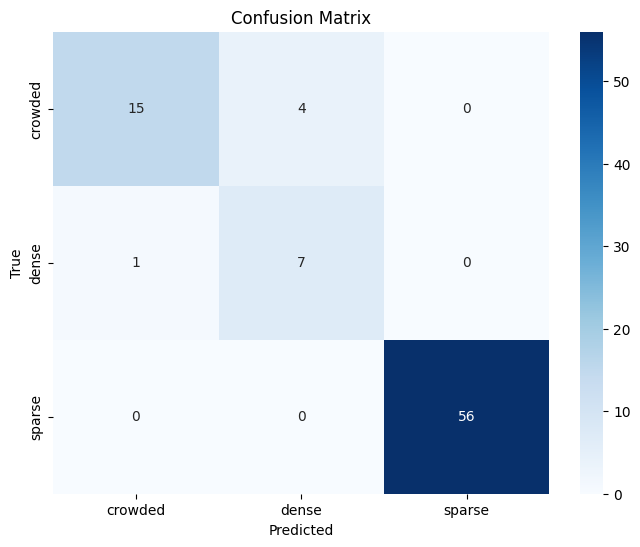


Classification Report:
              precision    recall  f1-score   support

     crowded       0.94      0.79      0.86        19
       dense       0.64      0.88      0.74         8
      sparse       1.00      1.00      1.00        56

    accuracy                           0.94        83
   macro avg       0.86      0.89      0.86        83
weighted avg       0.95      0.94      0.94        83



In [11]:
# Test the model on the validation set
test_model_with_predict(model, val_loader,"best_density_model.pt")

C:\Users\i_kaz\AppData\Local\Temp\ipykernel_47264\1464821615.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))  # Load t

Test Accuracy: 0.8723
Confusion Matrix:
 [[ 9  2  0]
 [ 0  3  3]
 [ 0  1 29]]


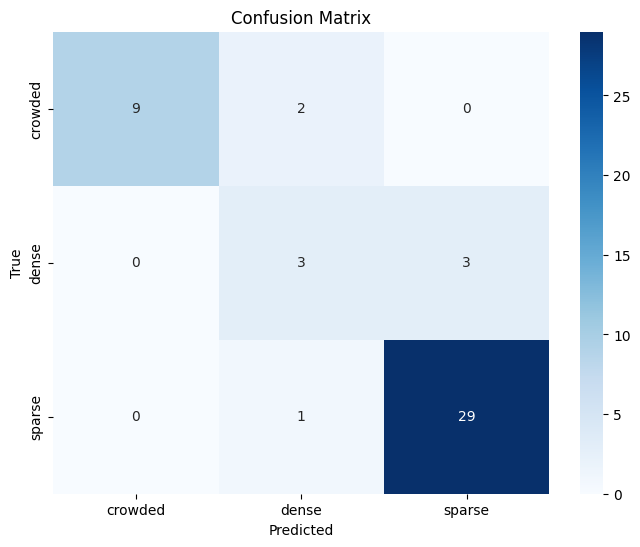


Classification Report:
              precision    recall  f1-score   support

     crowded       1.00      0.82      0.90        11
       dense       0.50      0.50      0.50         6
      sparse       0.91      0.97      0.94        30

    accuracy                           0.87        47
   macro avg       0.80      0.76      0.78        47
weighted avg       0.88      0.87      0.87        47



In [12]:
# Test the model on the test set
test_model_with_predict(model, test_loader,"best_density_model.pt")